# Neural Network with DBSCAN Clustering

This notebook demonstrates how to:
1. Generate a random dataset
2. Apply DBSCAN clustering to identify clusters
3. Create a neural network to classify the clusters
4. Train the model and visualize results

In [82]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 1: Generate Random Dataset

Dataset shape: (1050, 2)
Feature range - X1: [-13.12, 15.88]
Feature range - X2: [-11.89, 16.40]


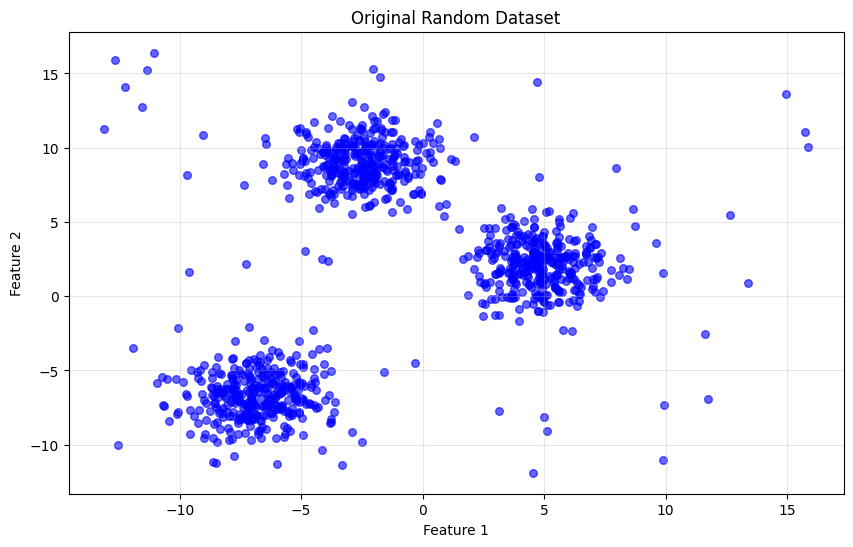

In [83]:
# Generate random dataset with multiple clusters
n_samples = 1000
n_centers = 3
n_features = 2

# Create dataset with natural clusters
X, _ = make_blobs(n_samples=n_samples, 
                  centers=n_centers, 
                  n_features=n_features, 
                  cluster_std=1.5, 
                  random_state=42)

# Add some noise points
noise_points = np.random.uniform(low=X.min()-2, high=X.max()+2, size=(50, 2))
X = np.vstack([X, noise_points])

print(f"Dataset shape: {X.shape}")
print(f"Feature range - X1: [{X[:, 0].min():.2f}, {X[:, 0].max():.2f}]")
print(f"Feature range - X2: [{X[:, 1].min():.2f}, {X[:, 1].max():.2f}]")

# Visualize the original dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.6, s=30)
plt.title('Original Random Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)
plt.show()

## Step 2: Apply DBSCAN Clustering

Number of clusters: 3
Number of noise points: 49


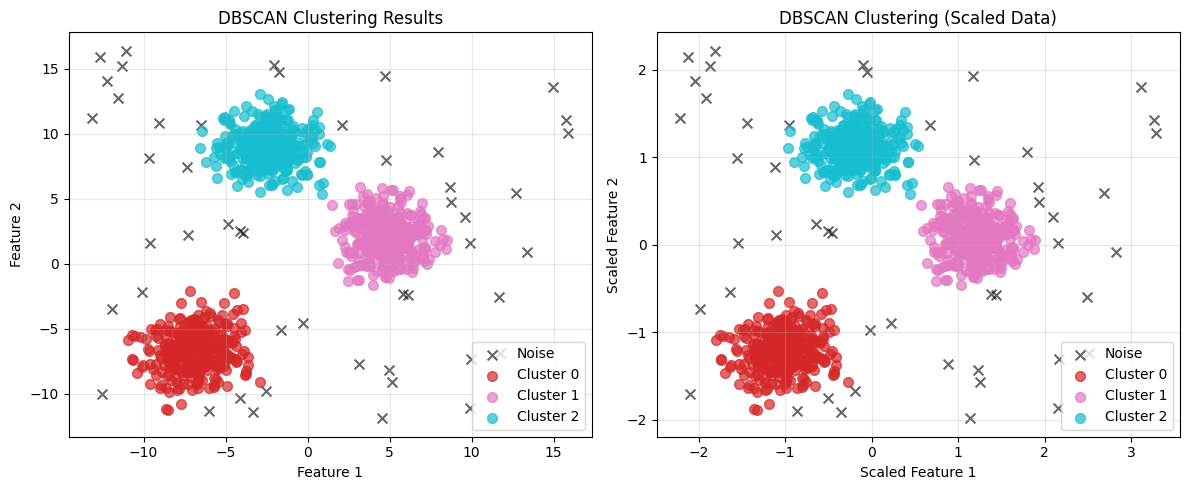

In [84]:
# Standardize the features for DBSCAN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN clustering
eps = 0.2  # Maximum distance between two samples for them to be considered neighbors
min_samples = 5  # Minimum number of samples in a neighborhood for a core point

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(X_scaled)

# Get cluster information
unique_labels = np.unique(cluster_labels)
n_clusters = len(unique_labels) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

# Visualize DBSCAN results
plt.figure(figsize=(12, 5))

# Plot 1: Original data with DBSCAN clusters
plt.subplot(1, 2, 1)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
for k, color in zip(unique_labels, colors):
    if k == -1:
        # Noise points in black
        class_member_mask = (cluster_labels == k)
        xy = X[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c='black', marker='x', s=50, alpha=0.6, label='Noise')
    else:
        class_member_mask = (cluster_labels == k)
        xy = X[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[color], s=50, alpha=0.7, label=f'Cluster {k}')

plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Scaled data with clusters
plt.subplot(1, 2, 2)
for k, color in zip(unique_labels, colors):
    if k == -1:
        class_member_mask = (cluster_labels == k)
        xy = X_scaled[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c='black', marker='x', s=50, alpha=0.6, label='Noise')
    else:
        class_member_mask = (cluster_labels == k)
        xy = X_scaled[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[color], s=50, alpha=0.7, label=f'Cluster {k}')

plt.title('DBSCAN Clustering (Scaled Data)')
plt.xlabel('Scaled Feature 1')
plt.ylabel('Scaled Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 3: Prepare Data for Neural Network

In [85]:
# Remove noise points for neural network training
valid_mask = cluster_labels != -1
X_clean = X_scaled[valid_mask]
y_clean = cluster_labels[valid_mask]

# Remap cluster labels to start from 0 (required for neural network)
label_mapping = {old_label: new_label for new_label, old_label in enumerate(np.unique(y_clean))}
y_mapped = np.array([label_mapping[label] for label in y_clean])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_mapped, test_size=0.2, random_state=42, stratify=y_mapped
)

print(f"Clean dataset: {X_clean.shape[0]} samples, {n_clusters} clusters")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Clean dataset: 1001 samples, 3 clusters
Training set: 800 samples
Testing set: 201 samples


## Step 4: Create and Train Neural Network

In [86]:
# Clear any existing models
tf.keras.backend.clear_session()

# Create the neural network model
def create_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile the model
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_mapped))

model = create_model(input_dim, num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Neural Network: {input_dim} → 64 → 32 → 16 → {num_classes}")
print(f"Total parameters: {model.count_params():,}")

Neural Network: 2 → 64 → 32 → 16 → 3
Total parameters: 2,851


In [87]:
# Train the model
# Ensure data types are correct
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

print("Training the neural network...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=0
)

print("Training completed!")

Training the neural network...
Training completed!


## Step 5: Evaluate Model Performance

Training Accuracy: 1.0000
Testing Accuracy: 1.0000


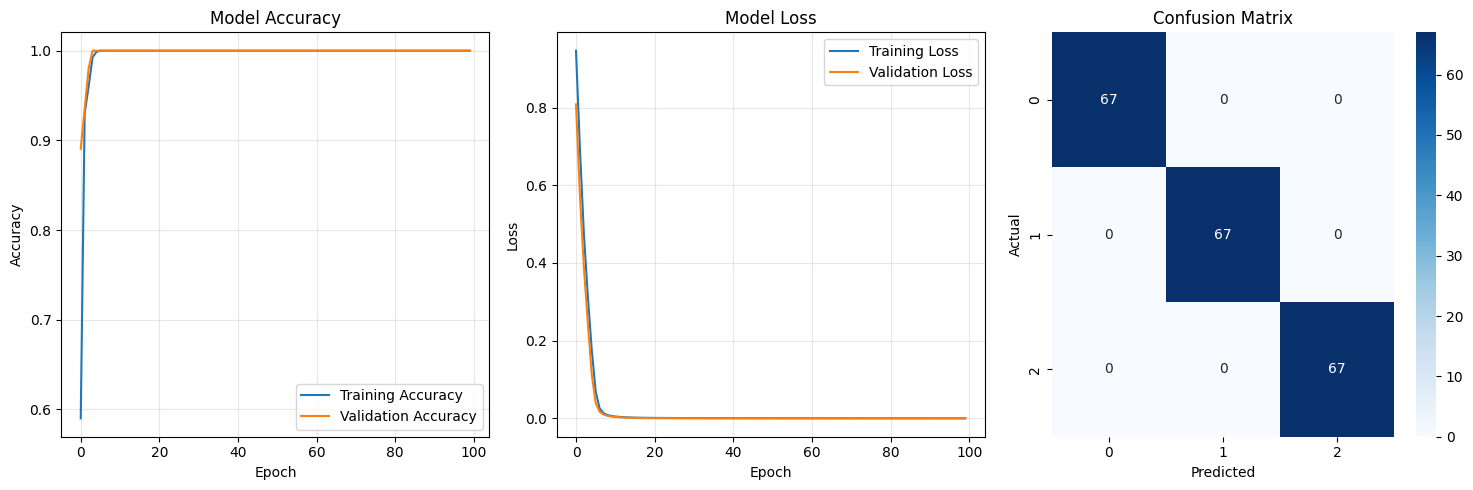

In [88]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot training history and confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

## Step 6: Visualize Results

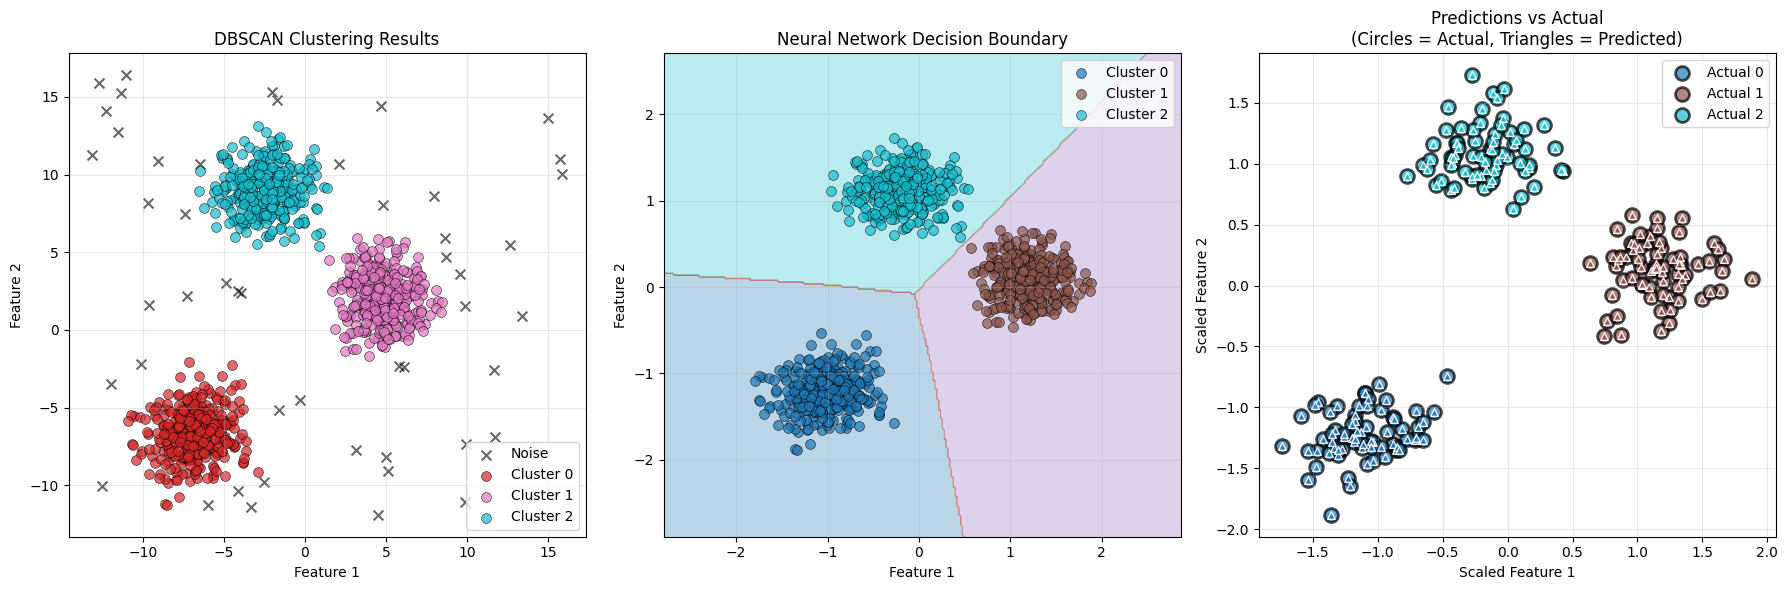

In [89]:
# Create decision boundary visualization
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(mesh_points, verbose=0)
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.tab10)
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(y))))
    for i, color in enumerate(colors):
        mask = y == i
        plt.scatter(X[mask, 0], X[mask, 1], c=[color], label=f'Cluster {i}', 
                   s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Visualize results
plt.figure(figsize=(18, 6))

# Plot 1: Original DBSCAN clusters
plt.subplot(1, 3, 1)
colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(cluster_labels))))
for k, color in zip(np.unique(cluster_labels), colors):
    if k == -1:
        class_member_mask = (cluster_labels == k)
        xy = X[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c='black', marker='x', s=50, alpha=0.6, label='Noise')
    else:
        class_member_mask = (cluster_labels == k)
        xy = X[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[color], s=50, alpha=0.7, 
                   label=f'Cluster {k}', edgecolors='black', linewidth=0.5)

plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Neural network decision boundary
plt.subplot(1, 3, 2)
plot_decision_boundary(model, X_clean, y_mapped, title='Neural Network Decision Boundary')

# Plot 3: Test set predictions vs actual
plt.subplot(1, 3, 3)
colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(y_mapped))))

# Plot actual labels (circles) and predicted labels (triangles)
for i, color in enumerate(colors):
    actual_mask = y_test == i
    pred_mask = y_pred_classes == i
    
    plt.scatter(X_test[actual_mask, 0], X_test[actual_mask, 1], c=[color], 
               s=100, alpha=0.7, marker='o', label=f'Actual {i}',
               edgecolors='black', linewidth=2)
    plt.scatter(X_test[pred_mask, 0], X_test[pred_mask, 1], c=[color], 
               s=30, alpha=0.9, marker='^', edgecolors='white', linewidth=1)

plt.title('Predictions vs Actual\n(Circles = Actual, Triangles = Predicted)')
plt.xlabel('Scaled Feature 1')
plt.ylabel('Scaled Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()